In [1]:
from shutil import copy
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
from tensorflow.keras import applications
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard


In [2]:
# Pre-processing
SIZE = 224

X_train = []
y_train = []

X_test = []
y_test = []

train_names = []
test_names = []

# Train data
for person in os.listdir('./signatures_dataset_script_split/train'):
    for signature in glob.glob('./signatures_dataset_script_split/train/' + person + '/*.*'):
        
        train_names.append(signature)
        img = cv2.imread(signature)
        # Transform BGR image into GRAY image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize all images to (SIZE, SIZE) images to have the same features
        img = cv2.resize(img, (SIZE, SIZE))
        X_train.append(img)
        
        if person[-1] == 'd':
            y_train.append(np.array(1))
        else:
            y_train.append(np.array(0))
            
# Normalize image pixels to be between 0 and 1
X_train = np.array(X_train)/255.0
y_train = np.array(y_train)

# Test data

for person in os.listdir('./signatures_dataset_script_split/test'):
    for signature in glob.glob('./signatures_dataset_script_split/test/' + person + '/*.*'):
        
        test_names.append(signature)
        img = cv2.imread(signature)
        # Transform BGR image into GRAY image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize all images to (SIZE, SIZE) images to have the same features
        img = cv2.resize(img, (SIZE, SIZE))
        X_test.append(img)
        
        if person[-1] == 'd':
            y_test.append(np.array(1))
        else:
            y_test.append(np.array(0))
            
# Normalize image pixels to be between 0 and 1
X_test = np.array(X_test)/255.0
y_test = np.array(y_test)


In [3]:
from tensorflow.keras.utils import to_categorical

# Normalize data
X_train_nn = X_train.copy()
X_test_nn = X_test.copy()
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()

y_train_nn = to_categorical(y_train_nn)

print("Data set mean: \n{}\n".format(np.mean(X_train_nn)))
print("X_train shape: \n{}\n".format(X_train_nn.shape))
print("y_train shape: \n{}\n".format(y_train_nn.shape))
print("X_test shape: \n{}\n".format(X_test_nn.shape))
print("y_test shape: \n{}\n".format(y_test_nn.shape))


Data set mean: 
0.9536430889630143

X_train shape: 
(240, 224, 224, 3)

y_train shape: 
(240, 2)

X_test shape: 
(60, 224, 224, 3)

y_test shape: 
(60,)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3_input (InputLa  [(None, 224, 224, 3)]    0         
 yer)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 34,910,754
Trainable params: 34,876,322
Non-trainable params: 34,432
____________________________________________

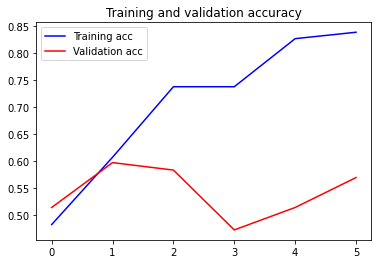

<Figure size 432x288 with 0 Axes>

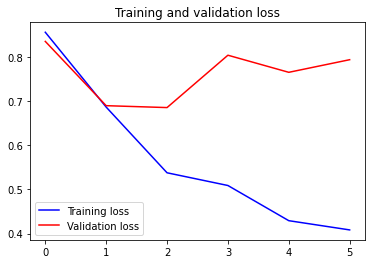

In [5]:
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()


earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]
progess = model.fit(X_train_nn,y_train_nn, batch_size=2,epochs=20, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [6]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
X_train_nn = intermediate_layer_model.predict(X_train_nn)
X_test_nn = intermediate_layer_model.predict(X_test_nn)

In [7]:
score = model.evaluate(X_train,y_train_nn,batch_size=BS)
y_pred_nn = np.argmax(model.predict(X_test,batch_size=BS), axis=1)

120/120 [==============================] - 11s 92ms/step - loss: 0.6518 - accuracy: 0.6542


In [8]:
lr = LogisticRegression()
lr.fit(X_train_nn, y_train)
y_pred = lr.predict(X_test_nn)

print('Accuracy: ', lr.score(X_test_nn, y_test_nn))
values = precision_recall_fscore_support(y_test_nn, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Accuracy:  0.5333333333333333
Precision: 0.5333333333333333
Recall: 0.5333333333333333
Fscore: 0.5333333333333333


In [9]:
# Linear SVM
classifier = svm.SVC(kernel="rbf")
classifier.fit(X_train_nn, y_train)
y_pred = classifier.predict(X_test_nn)

print('Accuracy: ', classifier.score(X_test_nn, y_test_nn))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_nn, y_pred)

print('Confusion matrix (undersample test dataset)')
print(cnf_matrix)

#Compute Recall metric (TP/(TP+FN))
confusion_matrix
print("Recall: ", cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[1][0])) 


Accuracy:  0.6166666666666667
Confusion matrix (undersample test dataset)
[[15 15]
 [ 8 22]]
Recall:  0.7333333333333333


In [10]:
# RBF SVM
classifier = svm.SVC(kernel="rbf")
classifier.fit(X_train_nn, y_train)
y_pred = classifier.predict(X_test_nn)

print('Accuracy: ', classifier.score(X_test_nn, y_test_nn))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_nn, y_pred)

print('Confusion matrix (undersample test dataset)')
print(cnf_matrix)

#Compute Recall metric (TP/(TP+FN))
confusion_matrix
print("Recall: ", cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[1][0])) 


Accuracy:  0.6166666666666667
Confusion matrix (undersample test dataset)
[[15 15]
 [ 8 22]]
Recall:  0.7333333333333333


In [11]:
# sigmoid SVM
classifier = svm.SVC(kernel="sigmoid")
classifier.fit(X_train_nn, y_train)
y_pred = classifier.predict(X_test_nn)

print('Accuracy: ', classifier.score(X_test_nn, y_test_nn))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_nn, y_pred)

print('Confusion matrix (undersample test dataset)')
print(cnf_matrix)

#Compute Recall metric (TP/(TP+FN))
confusion_matrix
print("Recall: ", cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[1][0])) 


Accuracy:  0.6833333333333333
Confusion matrix (undersample test dataset)
[[18 12]
 [ 7 23]]
Recall:  0.7666666666666667
